<a id="cont"></a>

## Table of Contents

<a href=#one>1. Introduction</a>

<a href=#two>2. EDA</a>

<a href=#three>3. Modelling Phase</a>

<a href=#four>4. Generating Predictions</a>

<a href=#five>5. Evaluating the Model</a>

 <a id="one"></a>
 # 1. Introduction

This notebook implements a model based aproach to create a recommender system.
It employs several models, but the required ones can be selected as needed because of the considerable runtime, especially during training.

## Installing packages
This notebook proceeds to install the required packages for building the recommender system.

In the case where the required package(s) isn't installed, the user shall have to pip install it.

In [2]:
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.pipeline import Pipeline
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Package for saving models
import pickle

## Reading in data
The notebook was first run on kaggle, hence that was the default directory for the data.

The user shall have to edit the following code block according to where their data is stored.

In [ ]:
# Example of importing data
train_df = pd.read_csv('/train.csv')
movies_df = pd.read_csv('/movies.csv')
imdb_df = pd.read_csv('/imdb_data.csv')
test_df = pd.read_csv('test.csv')
links_df = pd.read_csv('/links.csv')
tags = pd.read_csv('/tags.csv')
genome_scores = pd.read_csv('/genome_scores.csv')
genome_tags = pd.read_csv('/kagglegenome_tags.csv')

# Validating the data was loaded properly

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies_df.shape

(62423, 3)

<a id="two"></a>
## 2. EDA
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Outliers
- Outliers are data points that differ significantly from other observations. They can skew and mislead the training process of a machine learning model.
- This notebook therefore identifies them using statistical methods such as Z-scores or IQR (Interquartile Range) then decide whether to remove or transform the outliers depending on their impact on the dataset.

### Understanding Relationships Between Various Attributes and Structure of the Data
- This notebook uses correlation matrices to understand the relationships between numerical attributes.
- This notebook employs scatter plots, pair plots, and heatmaps to visualize and explore relationships.
- This notebook explores the structure of the data, including the distribution of values and the presence of any missing values.

### Recognizing Important Variables
- The user may use techniques like Random Forests, Gradient Boosting, or SHAP values to determine feature importance.
- The user may incorporate domain expertise to identify which variables are likely to be important.
- The user may conduct statistical tests to identify variables that have significant effects on the target variable.

By understanding the data through these steps, we ensure a robust foundation for building and evaluating machine learning models.
The user may do more EDA than has been done on this notebook as appropriate.

**Checking whether or not there are any missing values in the dataset**

In [ ]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("************")
print("Test: ")
print(str(test_df.isnull().sum()))
print("************")
print("Movies: ")
print(str(movies_df.isnull().sum()))
print("************")
print("Links: ")
print(str(links_df.isnull().sum()))
print("************")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("************")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("************")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

### Data Preparation

Data preparation is the process of preparing raw data so that it is suitable for further processing and analysis. Key steps include:

- **Collecting**: Gathering raw data from various sources.
- **Cleaning**: Removing or correcting any errors or inconsistencies in the data. This includes handling missing values, correcting data types, and removing duplicates.
- **Labeling**: Annotating data with labels that are required for supervised machine learning tasks. This involves identifying and marking the target variable.
- **Transforming**: Converting raw data into a format that is suitable for analysis. This includes normalization, scaling, encoding categorical variables, and feature engineering.
- **Exploring**: Analyzing the data to understand its structure and relationships. This step includes generating descriptive statistics and visualizing the data to identify patterns and insights.
- **Visualizing**: Creating graphical representations of the data to better understand distributions, trends, and relationships among variables. Common techniques include histograms, bar charts, scatter plots, and heatmaps.

By following these steps, raw data is transformed into a structured format that is ready for machine learning algorithms and further analysis.


In [7]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [9]:
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


**Creating a cleaner DataFrame for movie genres**

In [10]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


**Plotting genres from most common to least common**

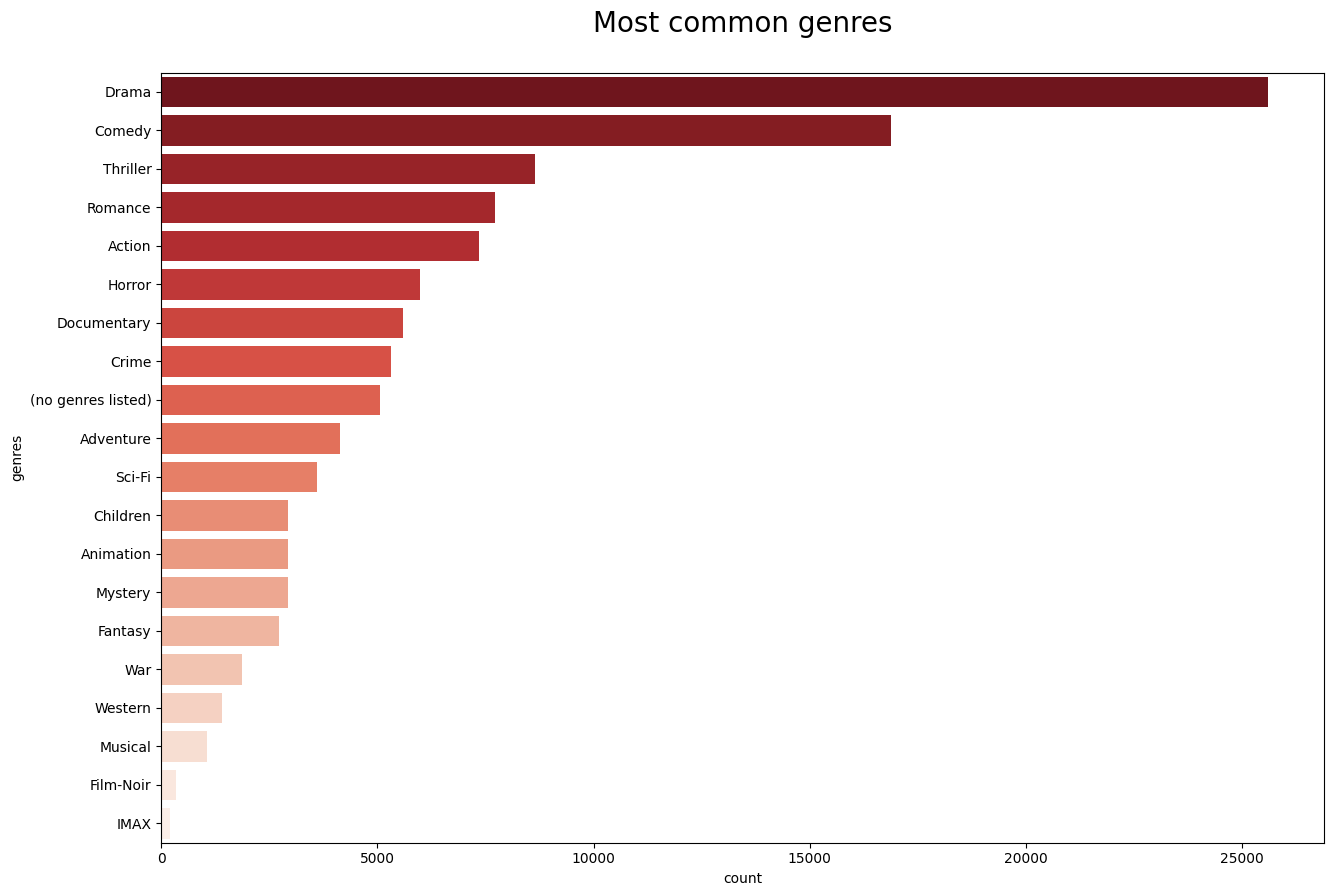

In [11]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

**Plotting the distribution of movie ratings**

In [ ]:
# group by ratings for visualization
ratings_df = train.groupby(['rating']).count()

#Plot showing the distribution of rating counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x=ratings_df.index,y='userId',data=ratings_df,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)
a.set_ylabel('Count in Millions',fontsize=15)
a.set_xlabel('Ratings',fontsize=15)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')

plt.show()

### Data Validation

**Verifying whether the imported testing and training datasets are suitable**

This step can be skipped if the testing and training datasets are split within the notebook.

In [ ]:
# Checking for the number of unique User ID's in the test data
test['userId'].nunique()

# Checking if there is any User ID in the test data but absent in the train data
test_case = test['userId'].unique()
train_case = train['userId'].unique()
print([id for id in test_case if id not in train_case])

**Sorting both tables according to the User IDs**

In [ ]:
# Sort train dataset by userId
train.sort_values(by=['userId'], inplace= True)
print('Train first five rows:', train.head())
print('\n Train Shape:', train.shape)


# Sort test dataset by userId
test.sort_values(by=['userId'], inplace= True)
print('\n\n Test first five rows:', train.head())
print('\n Test Shape:', train.shape)

<a id="three"></a>
## 3. Modelling phase
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


This part of the notebook builds and runs the model.

The first step taken is to create a reader object in order to parse through the ratings.

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

This notebook then makes use of a pipeline in order to find the best hyperparameters of the different models.

`Warning:` Training with a huge dataset may be very demanding for local runtimes.

In [ ]:
# Creating a pipeline that combines multiple models
pipe = Pipeline([
    ('model', None),
])

# Defining the hyperparameters for the pipeline
params = [
    {
        'model': [KNNWithMeans()],
        'model__k': [5, 10, 20, 30, 40, 50, 75, 100],
        'model__sim_options': [{'name': 'cosine', 'user_based': False},
                               {'name': 'cosine', 'user_based': True}]
    },
    {
        'model': [KNNBasic()],
        'model__k': [5, 10, 20, 30, 40, 50, 75, 100],
        'model__sim_options': [{'name': 'cosine', 'user_based': False},
                               {'name': 'cosine', 'user_based': True}]
    },
    {
        'model': [KNNBaseline()],
        'model__k': [5, 10, 20, 30, 40, 50, 75, 100],
        'model__sim_options': [{'name': 'cosine', 'user_based': False},
                               {'name': 'cosine', 'user_based': True}]
    },
    {
        'model': [SVD()],
        'model__n_factors': [25, 75, 100, 125, 150, 200],
        'model__n_epochs': [10, 20, 30, 40]
    },
    {
        'model': [SVDpp()],
        'model__n_factors': [10, 15, 20, 25, 30, 40],
        'model__n_epochs': [10, 20, 30, 40]
    },
    {
        'model': [NMF()],
        'model__n_factors': [5, 10, 15, 20, 25, 30],
        'model__n_epochs': [10, 20, 30, 40]
    },
    {
        'model': [SlopeOne()]
    },
    {
        'model': [CoClustering()],
        'model__n_cltr_u': [2, 3, 5, 8, 10, 20],
        'model__n_cltr_i': [2, 3, 5, 8, 10, 20],
        'model__n_epochs': [10, 20, 30, 40],
        'random_state': [42]
    },
    {
        'model': [BaselineOnly()]
    }
]

# Specifying Root Mean Squared Error as the scoring metric for GridSearchCV
scoring_metric = 'rmse'

# Using GridSearchCV to search over the hyperparameters
grid = GridSearchCV(pipe, params, measures=[scoring_metric], cv=5, refit=True)
grid.fit(data)

# Best score
print(f'Best RMSE: {grid.best_score[scoring_metric]}')

# Best parameters
print('Best parameters:')
print(grid.best_params[scoring_metric])

The following step is `optional`. The user may comment out any model(s) in the event they don't want to run all the models due to system resources and runtime.

In [ ]:
"""
# Train KNNBasic
knn_basic = KNNBasic()
knn_basic.fit(trainset)

# Train KNNWithMeans
knn_means = KNNWithMeans()
knn_means.fit(trainset)

# Train SVD
svd = SVD()
svd.fit(trainset)

# Train SVDpp
svdpp = SVDpp(cache_ratings=True)
svdpp.fit(trainset)

# Train NMF
nmf = NMF()
nmf.fit(trainset)

# Train SlopeOne
slope_one = SlopeOne()
slope_one.fit(trainset)

# Train KNNBaseline
knn_baseline = KNNBaseline()
knn_baseline.fit(trainset)

# Train CoClustering
coclustering = CoClustering()
coclustering.fit(trainset)

# Train BaselineOnly
baseline_only = BaselineOnly()
baseline_only.fit(trainset)
"""

After training the model(s), it may be useful to store it due to the lengthy training time.

In [ ]:
"""
model_save_path = "svd_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svd,file)
"""

An example of how to load the stored model.

In [ ]:
"""
model_load_path = "svd_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)
"""

<a id="four"></a>
# 4. Generating Predictions
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

At this stage, the notebook generates the average rating predictions from all the models.

In [ ]:
# Function to make combined prediction
def get_combined_prediction(uid, iid):
    predictions = [
        knn_basic.predict(uid, iid).est,
        knn_means.predict(uid, iid).est,
        svd.predict(uid, iid).est,
        svdpp.predict(uid, iid).est,
        nmf.predict(uid, iid).est,
        slope_one.predict(uid, iid).est,
        knn_baseline.predict(uid, iid).est,
        coclustering.predict(uid, iid).est,
        baseline_only.predict(uid, iid).est
    ]
    # Simple average of all predictions
    combined_pred = sum(predictions) / len(predictions)
    return combined_pred

In [ ]:
# Generating a list of predictions from the test set
# The list contains a tuple of userId, movieId and predicted rating for each row
predictions = []
for idx, row in test_df.iterrows():
    uid = row['userId']
    iid = row['movieId']
    est = get_combined_prediction(uid, iid)
    predictions.append((uid, iid, est))

# printing out the first five rows
predictions[:5]

The next step is `optional.` It concatenates the user and movie IDs after storing them in a DataFrame.

In [ ]:
"""
# creating a dataframe to store the predictions
final_preds = pd.DataFrame(predictions)

# joining userId and movieId columns and naming it 'id'
final_preds['id'] = final_preds[[0, 1]].astype(str).agg('_'.join, axis=1)

# dropping the userId and movieId columns
final_preds.drop(columns=[0, 1], axis=1, inplace=True)

# renaming the column with ratings to 'ratings'
final_preds.rename(columns={2:'rating'}, inplace=True)

# rearranging the columns to start with 'id' then 'rating'
final_preds = final_preds.reindex(sorted(final_preds.columns), axis=1)
print(final_preds.head())
print(final_preds.shape)
"""

If needed as a csv file, the code below is how to convert it.

In [15]:
#final_preds.to_csv('submission2.csv', index=False)

<a id="five"></a>
# 5. Evaluating the Model
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

From the generated predictions, this notebook proceeds to evaluate the performance of the model.

In [ ]:
# Evaluate the ensemble model
def evaluate_ensemble(testset):
    predictions = []
    for uid, iid, true_r in testset:
        est = get_combined_prediction(uid, iid)
        predictions.append((uid, iid, true_r, est))
    return predictions

ensemble_predictions = evaluate_ensemble(testset)

# Function to calculate RMSE for the ensemble predictions
def ensemble_rmse(predictions):
    mse = 0
    for uid, iid, true_r, est in predictions:
        mse += (true_r - est) ** 2
    rmse = (mse / len(predictions)) ** 0.5
    return rmse

# Calculate and print RMSE
rmse = ensemble_rmse(ensemble_predictions)
print(f'Ensemble RMSE: {rmse:.4f}')